# Predicción de abandono de clientes para Telco

# Licencia Notebook
Predicción de abandono de clientes para Telco

Copyright (C) 2024  Alvarado Ludwig & Pineda Laura

Este programa es software libre: puedes redistribuirlo y/o modificarlo bajo los términos de la Licencia Pública General de GNU, tal como fue publicada por la Free Software Foundation, ya sea la versión 3 de la Licencia, o (a tu elección) cualquier versión posterior.

Este programa se distribuye con la esperanza de que sea útil, pero SIN NINGUNA GARANTÍA; sin siquiera la garantía implícita de COMERCIABILIDAD o APTITUD PARA UN PROPÓSITO PARTICULAR. Consulta la Licencia Pública General de GNU para obtener más detalles.

Debes haber recibido una copia de la Licencia Pública General de GNU junto con este programa. Si no es así, visita https://www.gnu.org/licenses/.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/GPLv3_Logo.svg/1920px-GPLv3_Logo.svg.png" alt="GPL" width="400" height="200">


# Objetivo

Analizar los datos de cancelación de clientes (churn) de una compañía de telecomunicaciones para entender los factores que contribuyen a que los clientes decidan dejar el servicio. El objetivo final es desarrollar estrategias que reduzcan la tasa de rotación, mejorando así la retención de clientes y aumentando la rentabilidad de la empresa.

# Decisión a la que se quiere llegar

Identificar los factores clave que influyen en la cancelación de clientes y utilizar esta información para implementar acciones concretas que mejoren la experiencia del cliente y reduzcan la tasa de churn. 



# ¿Qué es la tasa *churn*?

Mide el número de clientes que han abandonado los servicios de la compañía, permite obtener esto en función de los clientes, la cantidad total en base al total de los clientes, o las pérdidas que ha generado ese abandono de clientes. Se usa mucho en marketing para saber en qué punto una empresa registra pérdidas [más información](https://www.iebschool.com/blog/que-es-churn-rate-marketing-digital/).



# Importar librerías

In [96]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 



# Exploración del set de datos

## Cargando y explorando los datos

### Cargar datos

Utilizando la función de `pandas`, `pd.read_csv()`, se carga el dataset de la siguiente manera, el archivo se encuentra separado por comas.

In [52]:
df = pd.read_csv('CustomerChurn.csv', delimiter=',')

### Tamaño del dataset y su estructura

Consiste mayormente de variables categóricas binarias sobre si el cliente cuenta con ciertos servicios o no. A su vez, se tiene la etiqueta $y$ que sería `churn`.

In [53]:
print('Registros:', df.shape[0])
print('Columnas:', df.shape[1])
print('Columnas:\n', df.columns)

Registros: 7043
Columnas: 21
Columnas:
 Index(['LoyaltyID', 'Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn'],
      dtype='object')


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [55]:
df.head()

,LoyaltyID,Customer ID,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,318537,7590-VHVEG,No,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,152148,5575-GNVDE,No,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,326527,3668-QPYBK,No,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,845894,7795-CFOCW,No,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,503388,9237-HQITU,No,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Análisis descriptivo

La variable `Total Charges` debería ser un flotante pero se está mostrando como un objeto. A continuación, se convierte a flotante. Sin embargo, primero se inspeccionar registros que tengan valores faltantes.

In [56]:
total_charge = df['Total Charges']
missing = total_charge[~total_charge.str.replace(".", "").str.isdigit()]
print("Número de valores faltantes de cargo: ", len(missing))
missing.head()

Número de valores faltantes de cargo:  11


488      
753      
936      
1082     
1340     
Name: Total Charges, dtype: object

In [57]:
df['Total Charges'] = df['Total Charges'].apply(pd.to_numeric, errors='coerce')

In [58]:
styled_df = (
    df.describe()
    .drop("count", axis=0)
    .style.background_gradient(axis=0, cmap="magma")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("background-color", "k")]}])
    .set_caption("Estadísticas resumidas")
)

styled_df

,LoyaltyID,Tenure,Monthly Charges,Total Charges
mean,550382.651001,32.371149,64.761692,2283.300441
std,260776.118690,24.559481,30.090047,2266.771362
min,100346.000000,0.000000,18.250000,18.800000
25%,323604.500000,9.000000,35.500000,401.450000
50%,548704.000000,29.000000,70.350000,1397.475000
75%,776869.000000,55.000000,89.850000,3794.737500
max,999912.000000,72.000000,118.750000,8684.800000


#### Análisis de columnas numéricas con barchart 

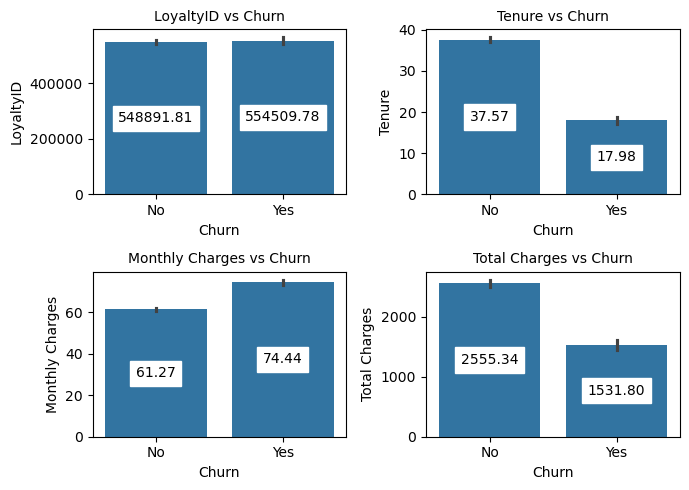

In [59]:
numeric_columns = df.select_dtypes(include=["int64", 'float64'])

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flatten()
for i, column in enumerate(numeric_columns):
    ax = axes[i]
    sns.barplot(data=df, x="Churn", y=column, ax=ax, estimator=np.mean)
    ax.set_title(f"{column} vs Churn", fontsize=10)

    for k in ax.containers:
        ax.bar_label(
            k, fontsize=10, label_type="center", backgroundcolor="w", fmt="%.2f"
        )
fig.add_axes(axes[-1])
plt.tight_layout()
plt.show()

**Interpretación de los resultados**

---

Meses de permanencia:

- Para clientes que no han cancelado, el promedio de permanencia en la empresa es de $37.57$ meses.
- Para clientes que han cancelado, el promedio de permanencia en la empresa es de $17.98$ meses.
- Esto sugiere que clientes que tienen más tiempo en la compañía, tienden a cancelar menos.

Cargos al mes:

- Para clientes que no han cancelado, el costo promedio mensual es de $\$ 61.27$ dólares.
- Para quientes que han cancelado, el costo promedio mensual es de $\$ 74.44$.
- Esto indica que los clientes que han cancelando tienden a tener costos mucho mayor al mes.



### Análisis Categórico

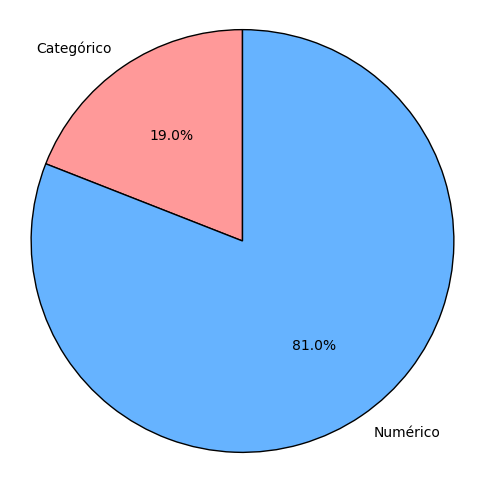

In [60]:
labels = ['Categórico', 'Numérico']
sizes = [4, 17]

colors = ['#ff9999','#66b3ff']

# Create the pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black'})

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

In [61]:
df.select_dtypes('object').columns

Index(['Customer ID', 'Senior Citizen', 'Partner', 'Dependents',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Churn'],
      dtype='object')

In [62]:
categorical_columns = df.dtypes[df.dtypes == 'object'].index.drop(
    [
        "Customer ID"
    ]
)

categorical_counts = pd.DataFrame(
    columns=["No", "Yes"], index=pd.MultiIndex.from_tuples([("Group 1", "A")])
)

for column in categorical_columns:
    table = pd.crosstab(index=df[column], columns=df["Churn"])
    index = pd.MultiIndex.from_tuples(
        list(zip([column] * df[column].nunique(), df[column].unique()))
    )
    table.index = index
    categorical_counts = pd.concat([categorical_counts, table])

categorical_counts.drop(categorical_counts.index[0], inplace=True)

categorical_counts.style.bar(
    axis=0, subset=["No", "Yes"], align=100, width=100, height=70, color="cyan"
)


In [63]:
cat_cols = df[categorical_columns]

fig, axes = plt.subplots(4, 4, figsize=(20, 18), dpi=500)
axes = axes.flatten()
fig.suptitle("Churn por categoría", fontsize=25, fontweight="bold", y=1)

for i, col in enumerate(cat_cols.columns):
    ax = axes[i]
    sns.countplot(data=df, x=col, hue="Churn", ax=ax, palette="Set2")
    ax.legend(frameon=True, facecolor="inherit", shadow=True)
    ax.set_title(f"Churn by {col}", fontsize=13)
    plt.tight_layout(pad=0.6)

    for i in ax.containers:
        ax.bar_label(i, fontsize=13)

plt.tight_layout()

/tmp/ipykernel_75398/1366951029.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=True, facecolor="inherit", shadow=True)


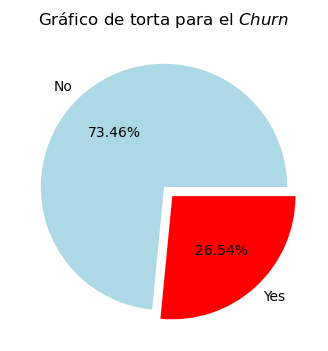

In [64]:
churn_label_count = df["Churn"].value_counts()
fig = plt.figure(figsize=(7, 4), dpi=100)
plt.pie(
    churn_label_count,
    autopct="%.2f%%",
    labels=churn_label_count.index,
    colors=["lightblue", "red"],
    explode=[0, 0.1],
)
plt.title("Gráfico de torta para el $Churn$")
plt.show()

**Interpretación de los resultados**

---

- La mayoría de clientes no cuentan con estado *senior*, es decir, mayores de edad.
- El $73.46\%$ de los registros aún son clientes de la empresa, mientras que el $26.54\%$ ya no lo son.
- Los clientes que más cancelan son aquellos que no cuentan con servicio de soporte y de seguridad en línea.

# Procesamiento de datos


## Buscar nulos y Dividir los datos

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LoyaltyID          7043 non-null   int64  
 1   Customer ID        7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure             7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless Billing  7043 

In [66]:
df.isnull().sum()

LoyaltyID             0
Customer ID           0
Senior Citizen        0
Partner               0
Dependents            0
Tenure                0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn                 0
dtype: int64

In [67]:
df['Total Charges'].fillna(df['Total Charges'].mean(), inplace=True)

/tmp/ipykernel_75398/2591824289.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total Charges'].fillna(df['Total Charges'].mean(), inplace=True)


In [88]:
df.isnull().sum()
categorical = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']

categorical       

['Senior Citizen',
 'Partner',
 'Dependents',
 'Phone Service',
 'Multiple Lines',
 'Internet Service',
 'Online Security',
 'Online Backup',
 'Device Protection',
 'Tech Support',
 'Streaming TV',
 'Streaming Movies',
 'Contract',
 'Paperless Billing',
 'Payment Method']

In [93]:
df[categorical]
data_encoded = pd.get_dummies(df[categorical], categorical, drop_first=True)

data_encoded = pd.concat([data_encoded, numeric_columns, df['Churn']], axis=1)
data_encoded

,Senior Citizen_Yes,Partner_Yes,Dependents_Yes,Phone Service_Yes,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_Fiber optic,Internet Service_No,Online Security_No internet service,Online Security_Yes,...,Contract_Two year,Paperless Billing_Yes,Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,LoyaltyID,Tenure,Monthly Charges,Total Charges,Churn
0,False,True,False,False,True,False,False,False,False,False,...,False,True,False,True,False,318537,1,29.85,29.85,No
1,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,152148,34,56.95,1889.50,No
2,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,True,326527,2,53.85,108.15,Yes
3,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,False,845894,45,42.30,1840.75,No
4,False,False,False,True,False,False,True,False,False,False,...,False,True,False,True,False,503388,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,False,True,True,True,False,True,False,False,False,True,...,False,True,False,False,True,810338,24,84.80,1990.50,No
7039,False,True,True,True,False,True,True,False,False,False,...,False,True,True,False,False,230811,72,103.20,7362.90,No
7040,False,True,True,False,True,False,False,False,False,True,...,False,True,False,True,False,155157,11,29.60,346.45,No
7041,True,True,False,True,False,True,True,False,False,False,...,False,True,False,False,True,731782,4,74.40,306.60,Yes


# Entrenar y evaluar modelo

## Entrenar y ajustar

In [94]:
X = data_encoded.drop('Churn', axis=1)
y = data_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [107]:
rf_model = RandomForestClassifier(n_estimators=600, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

## Evaluar

### F1-score, Precisión, Recall

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1559
         Yes       0.64      0.52      0.58       554

    accuracy                           0.80      2113
   macro avg       0.74      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



### Variables más importantes

In [109]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

1. Feature Total Charges (0.1670209008067381)
2. Feature Tenure (0.1533769557054163)
3. Feature Monthly Charges (0.14120556604796977)
4. Feature LoyaltyID (0.13249079089768612)
5. Feature Payment Method_Electronic check (0.04126901455337544)
6. Feature Internet Service_Fiber optic (0.0360635344911953)
7. Feature Contract_Two year (0.029973826549508573)
8. Feature Paperless Billing_Yes (0.023975811247974727)
9. Feature Online Security_Yes (0.022842332192799693)
10. Feature Contract_One year (0.02220456649360512)
11. Feature Tech Support_Yes (0.02141491152571311)
12. Feature Partner_Yes (0.019921128955296793)
13. Feature Online Backup_Yes (0.01922764451623084)
14. Feature Senior Citizen_Yes (0.018509104978271795)
15. Feature Multiple Lines_Yes (0.01797902749996552)
16. Feature Dependents_Yes (0.017572288602871654)
17. Feature Device Protection_Yes (0.01643807703614287)
18. Feature Streaming Movies_Yes (0.015328360354645541)
19. Feature Streaming TV_Yes (0.015164741076532783)
20. Feature 